In [9]:

# %matplotlib inline
from __future__ import division  # so that 1/2 == 0.5, and not 0
import math
from math import atan2, pi, sqrt, floor
from cmath import exp
import numpy as np
import kwant
import scipy.sparse.linalg as sla
from matplotlib import pyplot
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
from pylab import rcParams
%matplotlib notebook
from pylab import *

In [2]:
# Physical constants

h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)

#### Scaling:
# density:  n = (E/at)^2 * 8/(9*pi)

In [3]:
    W=1000
    L=1000
    w=120
    s=2


In [4]:
def rectangular(pos):
    x, y = pos
    return abs(x) < L and abs(y) < W

In [5]:
def QPC_tri(pos):
    l = abs((W-w)/s)
    x, y = pos
    if -l <= x <= l:
            return abs(x) <= l  and abs(y) < w + s*abs(x)
    else: 
        return abs(x) < L and abs(y) < W

In [11]:
def make_system(a=10,t=1.0):
    graphene = kwant.lattice.honeycomb(a,norbs=1)
    a, b = graphene.sublattices
    sys = kwant.Builder()
 
    def lead0_shape(pos):
        x, y = pos
        return -W  < y < W

    def lead1_shape(pos):
        x, y = pos
        return -W <  y < W

    def onsite(site,Vtip,xtip,ytip,Rtip):
        x, y = site.pos
        return Vtip /(1+((x-xtip)**2+(y-ytip)**2)/Rtip**2)
    
    sys[graphene.shape(rectangular, (0,0))] = onsite
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -t

    sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[graphene.shape(lead0_shape, (0, 0))] =  0
    lead0[graphene.neighbors()]= -t
    sys.attach_lead(lead0)

    
    sym1 = kwant.TranslationalSymmetry(graphene.vec((1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[graphene.shape(lead1_shape, (0, 0))] =  0
    lead1[graphene.neighbors()]=-t
    sys.attach_lead(lead1)


    return sys

/usr/lib/python3/dist-packages/kwant/linalg/lll.py:103: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefs = np.linalg.lstsq(vecs_orig.T, vecs.T)[0]
/usr/lib/python3/dist-packages/kwant/linalg/lll.py:144: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  center_coords = np.array(np.round(np.linalg.lstsq(basis.T, vec)[0]), int)
/usr/lib/python3/dist-packages/kwant/linalg/lll.py:144: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimens

<IPython.core.display.Javascript object>


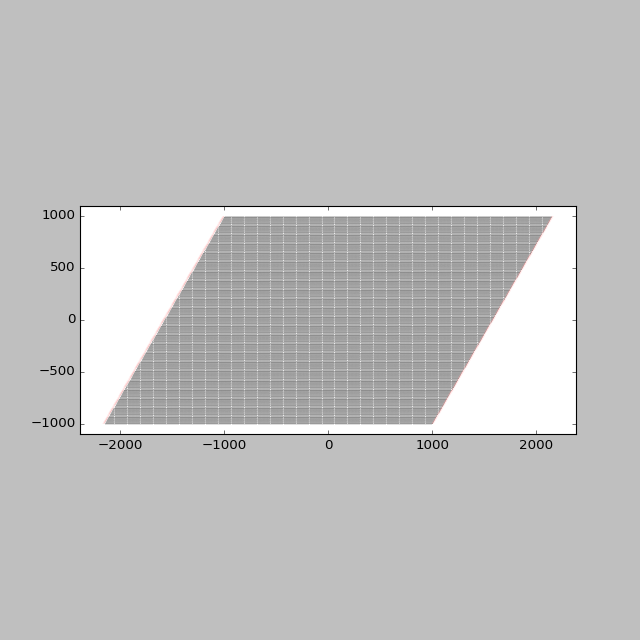

In [12]:
sys = make_system()

# Check that the system looks as intended.
kwant.plot(sys)
#     plt.show()

# Finalize the system.
syst = sys.finalized()


In [8]:
def onsite(site,Vtip,xtip,ytip,Rtip):
    x, y = site.pos
    return Vtip /(1+((x-xtip)**2+(y-ytip)**2)/Rtip**2)

In [10]:
#######################   Plot Current density from left lead   #################
xtip=0
ytip = 0
Rtip = 230    # Full width at half maximum (FWHM) of the potential distribution
# Vtips = np.linspace(0,0.8,4)
# density:  n = (E/at)^2 * 8/(9*pi)

####### Scale energy to Vbg ########
a = 10e-9
Vcnp = -1
C = 7.4e14
Vbg = linspace(-0.9,4,30)
n = C*(Vbg-Vcnp)
Energies = np.sqrt(n*9*3.14/8)*a
print(Energies)
print(n)
####### Scale Vtip #########
Vt = 7
Ct = 3.4e14
dn = Ct*(Vt)
Vtip = np.sqrt(dn*9*3.14/8)*a
print(Vtip)
print(dn)

Min = zeros(len(Energies))
for m,Ef in enumerate(Energies):
    ind = floor(Vbg[m] * 100) / 100
# vals=[onsite(syst.sites[n],Vtip,xtip,ytip,Rtip) for n in range(syst.graph.num_nodes)]
# kwant.plotter.map(syst, vals)
# plt.show()
    wf = kwant.wave_function(syst, energy = Ef,params = dict(Vtip = Vtip,xtip=xtip,ytip=ytip,Rtip=Rtip))
    J0 = kwant.operator.Current(syst)
    wf_left = wf(0)
    current = sum(J0(p) for p in wf_left)

    kwant.plotter.current(syst, current, cmap='gist_heat_r')
    plt.show()

    A,B = kwant.plotter.interpolate_current(syst, current, relwidth=None, abswidth=None, n=9)
    t = np.shape(A)
    print(t)

    x = np.linspace(-L-W*sqrt(2)/2,L+W*sqrt(2)/2,t[0])        
    y = np.linspace(-W,W,t[1])
    
    C = np.zeros([t[0],t[1]])
    for i in range(t[0]):
        for j in range(t[1]):
            C[i,j] = np.sqrt(A[i,j,0]**2 + A[i,j,1]**2)
                
#     Xn, Yn = np.meshgrid(x, y)
#     Fig, ax = subplots()
#     rcParams['figure.figsize'] = 9, 4
#     Fig = plt.pcolormesh(Xn, Yn, np.transpose(C), cmap='gist_heat_r')
#     cbar = plt.colorbar(Fig)

    Profile = C[:,t[1]//2]
    Fig2, ax = subplots()
    Fig2 = plt.plot(x,Profile,color=(0, 0, 1))


    #print line in file:
    
    myfile2='LDOS_line'+str(ind)+'.txt'
    fich2=open(myfile2,'w')
    for i in range(len(x)):
        fich2.write("%.7f %.7f \n" % (x[i],Profile[i])) 


[2.  1.5 1.  0.5 0. ]
[7.40000000e+13 1.99034483e+14 3.24068966e+14 4.49103448e+14
 5.74137931e+14 6.99172414e+14 8.24206897e+14 9.49241379e+14
 1.07427586e+15 1.19931034e+15 1.32434483e+15 1.44937931e+15
 1.57441379e+15 1.69944828e+15 1.82448276e+15 1.94951724e+15
 2.07455172e+15 2.19958621e+15 2.32462069e+15 2.44965517e+15
 2.57468966e+15 2.69972414e+15 2.82475862e+15 2.94979310e+15
 3.07482759e+15 3.19986207e+15 3.32489655e+15 3.44993103e+15
 3.57496552e+15 3.70000000e+15]
0.9169160266894673
2380000000000000.0


KeyboardInterrupt: 

In [ ]:
#######################   Plot Current density from left lead   #################
xtip=0
ytip = 0
Rtip = 230    # Full width at half maximum (FWHM) of the potential distribution
# Vtips = np.linspace(0,0.8,4)
# density:  n = (E/at)^2 * 8/(9*pi)

####### Scale energy to Vbg ########
a = 10e-9
Vcnp = -1
C = 7.4e14
Vbg = linspace(-0.8,2,6)
n = C*(Vbg-Vcnp)
Energies = np.sqrt(n*9*3.14/8)*a

####### Scale Vtip #########
Vt = 7
Ct = 3.4e14
dn = Ct*(Vt)
Vtip = np.sqrt(dn*9*3.14/8)*a


Min = zeros(len(Energies))
for m,Ef in enumerate(Energies):
    ind = floor(Vbg[m] * 100) / 100
# vals=[onsite(syst.sites[n],Vtip,xtip,ytip,Rtip) for n in range(syst.graph.num_nodes)]
# kwant.plotter.map(syst, vals)
# plt.show()
    wf = kwant.wave_function(syst, energy = Ef,params = dict(Vtip = Vtip,xtip=xtip,ytip=ytip,Rtip=Rtip))
    J0 = kwant.operator.Current(syst)
    wf_left = wf(0)
    current = sum(J0(p) for p in wf_left)

    kwant.plotter.current(syst, current, cmap='gist_heat_r')
    plt.show()

    A,B = kwant.plotter.interpolate_current(syst, current, relwidth=None, abswidth=None, n=9)
    t = np.shape(A)
    print(t)

    x = np.linspace(-L-W*sqrt(2)/2,L+W*sqrt(2)/2,t[0])        
    y = np.linspace(-W,W,t[1])
    
    C = np.zeros([t[0],t[1]])
    for i in range(t[0]):
        for j in range(t[1]):
            C[i,j] = np.sqrt(A[i,j,0]**2 + A[i,j,1]**2)
                
    Xn, Yn = np.meshgrid(x, y)
    Fig, ax = subplots()
    rcParams['figure.figsize'] = 9, 4
    Fig = plt.pcolormesh(Xn, Yn, np.transpose(C), cmap='gist_heat_r')
    cbar = plt.colorbar(Fig)

    Profile = C[:,t[1]//2]
    Fig2, ax = subplots()
    Fig2 = plt.plot(x,Profile,color=(0, 0, 1))


    #print line in file:
    
    myfile2='LDOS_line'+str(ind)+'.txt'
    fich2=open(myfile2,'w')
    for i in range(len(x)):
        fich2.write("%.7f %.7f \n" % (x[i],Profile[i])) 


In [1]:
for m,Ef in enumerate(Energies):
    ind = floor(Vbg[m] * 100) / 100
    myfile='LDOS_line'+str(ind)+'.txt'
#     fich2=open(myfile,'w')

    I = np.loadtxt(myfile)
    print(I)
    s = np.shape(I)
    Fig2, ax = subplots()
    Fig2 = plt.plot(I[:,0],I[:,1],color=(0, 0, 1))

NameError: name 'Energies' is not defined

<IPython.core.display.Javascript object>


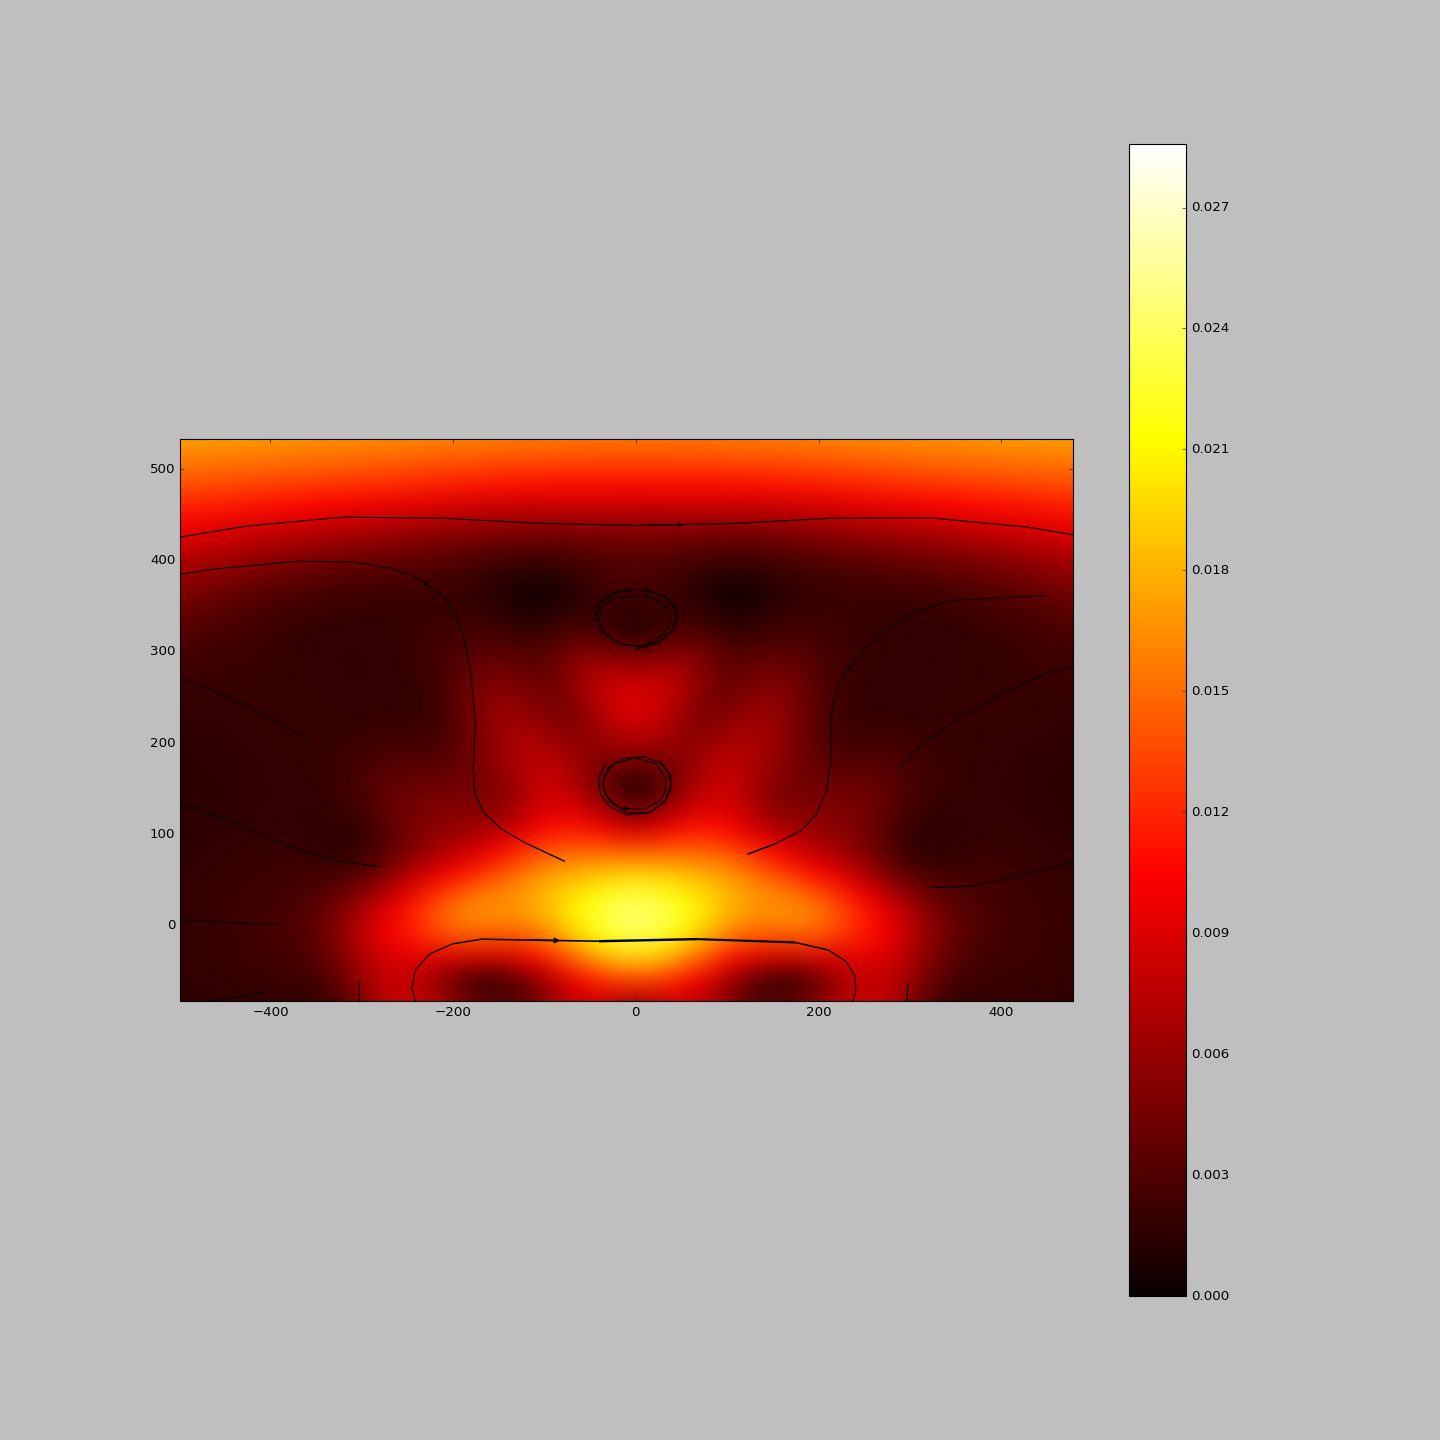

In [19]:
#######################   Plot Current density from left lead   #################
xtip=0
ytip = 0
Rtip = 230    # Full width at half maximum (FWHM) of the potential distribution
# Vtips = np.linspace(0,0.8,4)
# density:  n = (E/at)^2 * 8/(9*pi)

Ef = 0.5
# Vtips = linspace(1.9,1.9,1)
Vtips = ([1.9])#([0.5,1,1.5,1.9])print(Vtips)

# Min = zeros(len(Energies))
for m,Vtip in enumerate(Vtips):
#     myfile='Ef_0,5_Vtip_'+str(Vtip)+'.pdf'
#     fich=open(myfile,'w')
# vals=[onsite(syst.sites[n],Vtip,xtip,ytip,Rtip) for n in range(syst.graph.num_nodes)]
# kwant.plotter.map(syst, vals)

    wf = kwant.wave_function(syst, energy = Ef,params = dict(Vtip = Vtip,xtip=xtip,ytip=ytip,Rtip=Rtip))
    J0 = kwant.operator.Current(syst)
    wf_left = wf(0)
    current = sum(J0(p) for p in wf_left)

#     fig, ax = plt.subplots()
    rcParams['figure.figsize'] = 18,18
    kwant.plotter.current(syst, current, cmap='hot')#,colorbar=None)
#     plt.show()
    plt.savefig('colorbar_'+str(Vtip)+'.pdf')
#     kwant.plotter.current(syst, current, cmap='gist_heat_r',colorbar=None, file=fich)



<IPython.core.display.Javascript object>


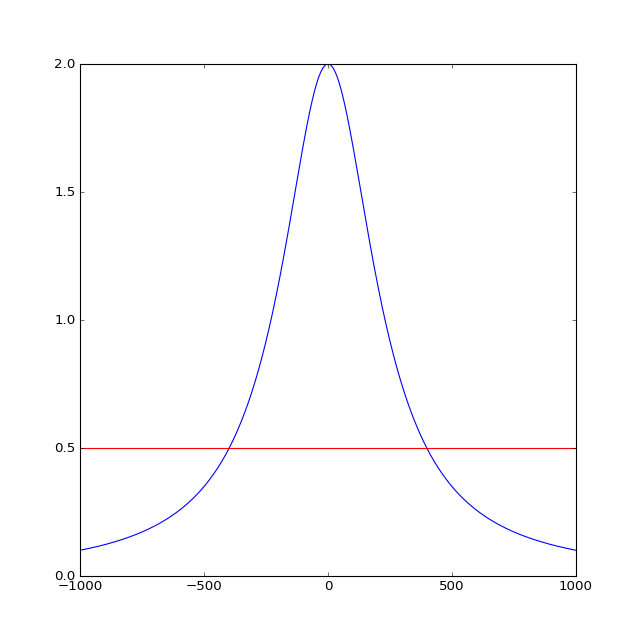

In [10]:
xtip = 0
Vtip = 2
Rtip = 230
x = linspace(-1000,1000,1000)
V = Vtip /(1+((x-xtip)**2/Rtip**2))
Ef = 0.5
rcParams['figure.figsize'] = 8,8
fig, ax = plt.subplots()
plt.plot(x,V)
plt.axhline(y=0.5, color='r')
# plt.show()

In [32]:
a = 10e-9
E = np.array([0.5,1,1.5,1.9])
n = (E/a)**2 * 8/(9*pi)*1e-15


print(n)

[ 0.70771408  2.83085633  6.36942675 10.21939137]
